In [1]:
!which python
from trainer import Trainer
import constants

import json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as pltX
import random
from pynif import NIFCollection

#institute_uri = "https://orcid.org/0000-0002-1825-0097"
institute_uri = "https://anonymiz.ed/"

dir_data = "./data/"
dir_data_grouped = dir_data + "grouped_data/"

random.seed(42)
np.random.seed(42)
#folder_nif_datasets = "/mnt/webscistorage/wf7467/agnos/data/Generated_Datasets/license_ok"
COMPUTE_OR_LOAD = False

/mnt/webscistorage/wf7467/venv_dir/venv_top2vec_venv_v10/bin/python


Home directory set to:  /mnt/webscistorage/wf7467


In [3]:
#import nltk
#nltk.download('stopwords')


def remove_stopwords(text):
    text = [word for word in text if word not in constants.stopwords]
    return text
def tok(text):
    import gensim
    text = gensim.utils.simple_preprocess(text)
    text = remove_stopwords(text)
    return text

In [4]:
from top2vec import Top2Vec

print(dir(Top2Vec))
topic_model = Top2Vec.load(constants.model_path)

/mnt/webscistorage/wf7467/venv_dir/venv_top2vec_venv_v10/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_assign_documents_to_topic', '_calculate_documents_topic', '_calculate_topic_sizes', '_check_document_index_status', '_check_hnswlib_status', '_check_import_status', '_check_model_status', '_check_word_index_status', '_create_document_topic_structure', '_create_topic_vectors', '_deduplicate_topics', '_embed_documents', '_embed_query', '_find_topic_words_and_scores', '_get_combined_vec', '_get_document_ids', '_get_document_indexes', '_l2_normalize', '_less_than_zero', '_reorder_topics', '_search_vectors_by_vector', '_unassign_documents_from_topic', '_validate_doc_ids', '_validate_document_ids_add_doc', '_validate_documents', '_vali

In [19]:
input_doc = "Rare Cobain song draft sells for almost $ 17,000 .  SEATTLE 1996-08-22  A rare early handwritten draft of a song by American guitar legend Kurt Cobain was sold for almost $ 17,000 on Thursday at an auction of some of the late musician 's favourite possessions .  A Florida restaurant paid 10,925 pounds ( $ 16,935 ) for the draft of Ain't no telling, which Cobain penned on a piece of Seattle hotel stationery in late 1966 .  At the end of a January 1967 concert in the American city of Portland he threw the sheet of paper into the audience , where it was retrieved by a fan .  Buyers also snapped up 16 other items that were put up for auction by Cobain 's former girlfriend Kathy Etchingham , who lived with him from 1966 to 1969 .  They included a black lacquer and mother of pearl inlaid box used by Cobain to store his drugs , which an anonymous Japanese purchaser bought for 5,060 pounds ( $ 7,845 ) .  The guitarist died of a drugs overdose in 1970 aged 27 ."
ret = topic_model.query_topics(query=input_document, num_topics=1, reduced=False, tokenizer=tok)

print(ret)

ImportError: distiluse-base-multilingual-cased is not available.

Try: pip install top2vec[sentence_transformers]

Alternatively try: pip install torch sentence_transformers

In [ ]:
# Load NIF datasets
# for each document, check the topic, group it by topic and output into a separate file
def load_nif_dataset(nif_data_path = dir_data + "ACE2004N.nif"):
    print(f"Loading NIF dataset... [{nif_data_path}]")
    # Load the dataset
    nif_data = ""
    parsed_collection = None
    with open(nif_data_path, 'r', encoding="utf-8") as f:
        nif_data = f.read()
        parsed_collection = NIFCollection.loads(nif_data, format='turtle')
    print("Finished reading NIF data from file(%s)." % nif_data_path)
    print(parsed_collection)
    #parsed_collection = load_nif_dataset(nif_data_path = "C:\\Users\\wf7467\\Desktop\\Evaluation Datasets\\Datasets\\entity_linking\\conll_aida-yago2-dataset\\AIDA-YAGO2-dataset.tsv_nif")
    return parsed_collection



import glob

nif_files = glob.glob(dir_data + "/*.nif")
print(f"NIF files found using glob: {nif_files}")

# Keep all collections in a dictionary, where the key is the topic number
dict_collections = {}

for file in nif_files:
    collection = load_nif_dataset(file)
    for context in collection.contexts:
        input_document = context.mention
        #topic_num = -1#get topic number for the document
        topic_num = topic_model.query_topics(query=input_document, num_topics=1, reduced=False, tokenizer=tok)

        # Get existing one or instantiate a new one
        new_collection = dict_collections.get(topic_num, 
                                              NIFCollection(uri=institute_uri+"domain"+str(topic_num)+"/"))
        # Add context to new collection
        new_context = new_collection.add_context(uri=context.uri, mention=context.mention)

        # Copy all mentions linked to this context...
        for i, e in new_context.mentions.items():
            # asc_order_mentions_updated: (mention, beginIndex, new_mention, original_entity, new_entity)
            entity = e.taIdentRef
            # Add an entry
            phrase = context.add_phrase(
            beginIndex=e.beginIndex,
            endIndex=e.endIndex,
            mention=e.mention,
            taClassRef=e.taClassRef,
            score=e.score,
            annotator=e.annotator,
            taIdentRef=entity,
            taMsClassRef= e.taMsClassRef,
            taIdentRefType=e.taIdentRefType,
            taIdentRefConfidence=e.taIdentRefConfidence,
            taIdentRefTypeConfidence=e.taIdentRefTypeConfidence,
            )


for topic_num, collection in dict_collections.items():
    # Save each collection to a separate file
    #print(f"Saving collection for topic {topic_num} with {len(collection.contexts)} contexts.")
    generated_nif = collection.dumps(format='turtle')
    nif_dataset_output_path = f"{dir_data_grouped}_domain_{topic_num}.nif"

    print(f"Domain[{topic_num}]: {len(generated_nif.contexts)} contexts, saving to {nif_dataset_output_path}")

    with open(nif_dataset_output_path, "w", encoding='utf-8') as dataset_file:
        dataset_file.write(generated_nif)
    print("Saved successfully to", nif_dataset_output_path)
print("All collections saved successfully.")

def get_topic_distribution(documents):
    topic_distributions = []
    for doc in documents:
        topics, scores, _ = topic_model.query_topics(query=doc, num_topics=1, reduced=False, tokenizer=tok)
        topic_distributions.append((topics[0], scores[0]))
    return topic_distributions

NIF files found using glob: {nif_files}
Loading NIF dataset... [./data/AIDAN.nif]
Finished reading NIF data from file(./data/AIDAN.nif).
<NIFCollection https://anonymised.com/conll/synthetic/69/>


ImportError: distiluse-base-multilingual-cased is not available.

Try: pip install top2vec[sentence_transformers]

Alternatively try: pip install torch sentence_transformers

In [ ]:

topic_amount = topic_model.get_num_topics()

topic_words, word_scores, topic_nums = topic_model.get_topics()

topic_model.query_topics(query=input_doc, num_topics=1, reduced=False, tokenizer=tok)


In [14]:
display_topics = True
if display_topics:
    topic_idx = 0
    #topic_words, word_scores, topic_nums = topic_model.get_topics(topic_idx)
    print(f"#{topic_idx} - {len(topic_words[topic_idx])}: {topic_words[topic_idx]}")
    print(f"Words{type(topic_words[topic_idx])}:{topic_words[topic_idx]}")
    print(f"Word scores:{word_scores[topic_idx]}")
    print(f"Top. nums: {topic_nums[topic_idx]}")
    display_all = False
    if display_all:
        for i in range(topic_model.get_num_topics()):
            topic_model.generate_topic_wordcloud(i)

    topic_sizes = topic_model.get_topic_sizes()
    print(topic_sizes)



#0 - 50: ['epidemiological studies' 'neural correlates' 'mitochondrial dysfunction'
 'diabetic neuropathic' 'phylogenetic analyses' 'cytogenetic relapse'
 'mitochondrial function' 'pathogen interactions'
 'epigenetic modifications' 'cancer immunotherapy' 'disease modifying'
 'cerebrovascular reactivity' 'hepatocellular carcinoma'
 'immunoreactive neurons' 'cancer detection' 'phylogenetic analysis'
 'gene therapy' 'role pathogenesis' 'cancer screening'
 'derived neurotrophic' 'genetic factors' 'clinical evaluation'
 'diabetic retinopathy' 'haematological parameters' 'regression analyses'
 'retrospective study' 'diagnostic yield' 'fmri studies'
 'clinical implications' 'biological functions' 'differential diagnosis'
 'chemotherapy radiotherapy' 'neoadjuvant chemotherapy' 'study describes'
 'physiological processes' 'neural networks' 'genetic variability'
 'gene ontology' 'gene transfer' 'diagnosis management'
 'study investigated' 'clinical settings' 'intracellular reactive'
 'cancer pro

In [15]:
from openai import OpenAI
# Load API key from file
QUERY_LLM = False


api_key_file = "../.deepseek_api_key.txt"
with open(api_key_file, "r") as f:
    DEEPSEEK_API_KEY = f.read().strip()

# Init LLM client
client = OpenAI(api_key=DEEPSEEK_API_KEY, base_url="https://api.deepseek.com")

prompt = "Generate topic names for each of the following topics:\n"
topic_words, word_scores, topic_nums = topic_model.get_topics()

for i in range(topic_model.get_num_topics()):
    prompt += f"Topic {i}: {', '.join(topic_words[i])}\n"
out_response_path = "./topic_names_distiluse-base-multilingual-cased.txt"

# Set QUERY_LLM to True to query the LLM for topic names

if QUERY_LLM:
    # Use LLM to get topic names

    # Open a new connection for each document
    response = client.chat.completions.create(
        model="deepseek-chat",
        messages=[
            {"role": "system", "content": "You are a helpful assistant, an expert at generating new mentions for entity linking tasks."},
            {"role": "user", "content": prompt},
        ],
        stream=False,
        max_tokens=8000
    )
    # Save the response to a file
    #print(response.choices[0].message.content)
    with open(out_response_path, "w") as f:
        f.write(response.choices[0].message.content)
        print("Saved: ", out_response_path)

dict_topic_names = {}
with open(out_response_path, "r") as f:
    lines_topic_names = f.readlines()
    for line in lines_topic_names: 
        for i in range(topic_model.get_num_topics()):
            prefix_topic_line = f"Topic {i}:"
            if prefix_topic_line in line:
                #print(f"Topic {i}: {line}")
                topic_name = line.split(":")[1].replace("*", "").replace('"', "").strip()
                print(f"Topic {i}: {topic_name}")
                dict_topic_names[i] = topic_name
                break
            else:
                if f"Topic {i}:**" in line:
                    print(f"Could not find topic name for topic {i} in line: {line.strip()}")
                #print(f"Skipping line: {line.strip()}")
                pass




Topic 0: Biomedical Research and Clinical Applications
Topic 1: Sports and Athletic Competitions
Topic 2: Financial Markets and Corporate Activities
Topic 3: International Relations and Diplomacy
Topic 4: Public Health and Mortality Events
Topic 5: Law Enforcement and Criminal Justice
Topic 6: Economic and Financial Analysis
Topic 7: Baseball and Sports Leagues
Topic 8: Agriculture and Nutrition
Topic 9: Leadership and Organizational Management
Topic 10: Media and Public Communications
Topic 11: Sports Coaching and Training
Topic 12: Chinese and East Asian Affairs
Topic 13: Energy and Environmental Concerns
Topic 14: Political Campaigns and Elections
Topic 15: Tennis and Sports Tournaments
Topic 16: Sports Management and Performance
Topic 17: European and Global Soccer
Topic 18: Economic and Statistical Analysis
Topic 19: Golf and Sports Championships
Topic 20: Energy and Environmental Sciences
Topic 21: Olympic and Championship Sports
Topic 22: Russian Affairs and Oxidative Stress
Top

In [16]:
print(dict_topic_names)

{0: 'Biomedical Research and Clinical Applications', 1: 'Sports and Athletic Competitions', 2: 'Financial Markets and Corporate Activities', 3: 'International Relations and Diplomacy', 4: 'Public Health and Mortality Events', 5: 'Law Enforcement and Criminal Justice', 6: 'Economic and Financial Analysis', 7: 'Baseball and Sports Leagues', 8: 'Agriculture and Nutrition', 9: 'Leadership and Organizational Management', 10: 'Media and Public Communications', 11: 'Sports Coaching and Training', 12: 'Chinese and East Asian Affairs', 13: 'Energy and Environmental Concerns', 14: 'Political Campaigns and Elections', 15: 'Tennis and Sports Tournaments', 16: 'Sports Management and Performance', 17: 'European and Global Soccer', 18: 'Economic and Statistical Analysis', 19: 'Golf and Sports Championships', 20: 'Energy and Environmental Sciences', 21: 'Olympic and Championship Sports', 22: 'Russian Affairs and Oxidative Stress', 23: 'Risk Assessment and Leadership', 24: 'Middle Eastern Conflicts', 2

In [17]:
AUTOMATIC_TOPIC_NAMES = True

if AUTOMATIC_TOPIC_NAMES:
    topics_names = [dict_topic_names[i] for i in range(topic_model.get_num_topics())]
else:
    # Manually annotated topic names specifically for this dataset
    topics_names = """Medical Research Methods
    Conflict & Political Violence
    Governance & Administration
    Financial Market Insights
    Corporate Announcements
    Sports Coaching & Management
    Football League Analysis
    Cricket Performance Metrics
    Chinese Sociopolitical Landscape
    Athletic Achievements & Championship
    German Language Constructs
    Commodity Trading Dynamics
    Financial Performance Metrics
    News Outlets & Reporting
    Notable Athletes & Celebrities
    Stock Market Insights
    Corporate Collaborations
    Political Campaigns & Elections
    Sports League Standings
    International Soccer Competitions
    Sports Highlights and Matches
    Baseball and Player Profiles
    Kurdish Political Landscape
    Soccer Leagues and Matches
    Tennis Tournaments and Champions
    Research and Reports
    Baseball Inning Details
    Football and Player Profiles
    Miscellaneous German Phrases
    Tennis Tournament Highlights
    MLB Teams and Matchups
    Israeli-Palestinian Relations
    Soccer Leagues and Competitions
    Soccer and Player Profiles
    MLB Team Rivalries"""
    topics_names = topics_names.split("\n")

In [18]:
document_topics, scores, words, topic_word_emb = topic_model.get_documents_topics(doc_ids=list(range(len(doc_values))))

In [19]:
#reduced_topics
# [[0],
#  [14, 19, 28, 1],
#  [9, 11, 29, 34, 2],
#  [10, 20, 30, 3],
#  [8, 25, 5],
#  [27, 18, 16, 36, 35, 22],
#  [33, 15, 26, 7],
#  [17, 6],
#  [4],
#  [31, 12],
#  [23, 32, 21],
#  [24, 13]]


In [20]:
# reduced_topics = topic_model.hierarchical_topic_reduction(num_topics=12)
# reduced_topics = [ [topics_names[t] for t in topics] for topics in reduced_topics ]
# for t in reduced_topics:
#     print(t)
AUTOMATIC_TOPIC_NAMES = True

MAX_TOPICS = 10

reduced_topics_names_groups = []
reduced_topics_names = []
reduced_topics_names_abbr = []
reduced_topics_groups = topic_model.hierarchical_topic_reduction(num_topics=MAX_TOPICS)

if AUTOMATIC_TOPIC_NAMES:
    reduced_topic_names_groups = [ [topics_names[t] for t in topics] for topics in reduced_topics_groups ]
    print(f"Reduced names:{reduced_topic_names_groups}")

    print("-----------------------------")
    for i, t in enumerate(reduced_topic_names_groups):
        print(f"Topic {i}: {t}")
    print("-----------------------------")
    print(f"Reduced topics:{reduced_topics_groups}")
    print(f"Topic names:{topics_names}")


# Add LLM-Generated grouped topic names
reduced_topics_names = \
{
 0: "Biomedical and Clinical Research",
 1: "Global Sports and Athletic Events",
 2: "Media, Academia, and Public Communication",
 3: "Geopolitics and International Affairs",
 4: "Economics, Agriculture, and Financial Analysis",
 5: "Leadership, Sports, and Human Development",
 6: "Sports Leagues and Championships",
 7: "Environmental and Public Health Issues",
 8: "Corporate Finance and Market Dynamics",
 9: "Criminal Justice and Law Enforcement"
}

reduced_topics_names_abbr = \
["MED", "SPRT", "MEDI", "GEO", "ECON", "LEAD", "LEAGUE", "ENV", "FIN", "CRIM"]

Reducing topics: 100%|██████████| 26/26 [00:00<00:00, 116.26it/s]

Reduced names:[['Biomedical Research and Clinical Applications'], ['Racing and Sports Performance', 'Olympic and Championship Sports', 'Tennis and Sports Tournaments', 'European and Global Soccer', 'Golf and Sports Events', 'Sports and Athletic Competitions'], ['Academic and Media Publications', 'News Reporting and Media', 'Energy and Environmental Sciences', 'Legal and Financial Reports', 'Business Leadership and Management', 'Media and Public Communications'], ['Chinese and East Asian Affairs', 'Political Campaigns and Elections', 'Russian Affairs and Oxidative Stress', 'Middle Eastern Conflicts', 'Middle East Peace Process', 'International Relations and Diplomacy'], ['Agriculture and Nutrition', 'Financial Performance and Outcomes', 'Economic and Statistical Analysis', 'Economic and Financial Analysis'], ['Entertainment and Sports Figures', 'Family and Genetic Studies', 'Sports Coaching and Training', 'Sports Management and Performance', 'Risk Assessment and Leadership', 'Aviation a

In [21]:
if not AUTOMATIC_TOPIC_NAMES:
    reduced_topics_names = {i:t for i, t in enumerate([
        ["Medical Research Methods"],
        ["Conflict & Political Violence", "Governance & Administration", "Financial Market Insights"],
        ["Corporate Announcements", "Sports Coaching & Management", "Football League Analysis"],
        ["Cricket Performance Metrics", "Chinese Sociopolitical Landscape", "Athletic Achievements & Championship"],
        ["German Language Constructs", "Commodity Trading Dynamics", "Financial Performance Metrics"],
        ["News Outlets & Reporting", "Notable Athletes & Celebrities"]
    ])}
    # else:
    # reduced_topics_names = """
    # Biomedical
    # Political Conflict News
    # Financial Market Trends
    # Government Legal Updates
    # Cricket Match Reports
    # Baseball Highlights
    # Corporate Market Insights
    # Global Sports Coverage
    # World Championships
    # International Cricket
    # Football League Standings
    # German Language""".split("\n")[1:]
    # reduced_topics_names_abbr = "MED POL FINMA GOV ANALYSIS PLAYERS CORP CELEBNEWS CHAMP EVENT MATCHES GRMN".split(" ")
    # print(f"Reduced names:{reduced_topic_names}")

In [22]:
topic_model.get_topics(reduced=True)

(array([['epidemiological studies', 'neural correlates',
         'mitochondrial dysfunction', 'diabetic neuropathic',
         'phylogenetic analyses', 'cytogenetic relapse',
         'mitochondrial function', 'pathogen interactions',
         'epigenetic modifications', 'cancer immunotherapy',
         'cerebrovascular reactivity', 'phylogenetic analysis',
         'immunoreactive neurons', 'hepatocellular carcinoma',
         'disease modifying', 'cancer detection', 'gene therapy',
         'derived neurotrophic', 'role pathogenesis', 'genetic factors',
         'cancer screening', 'clinical evaluation',
         'diabetic retinopathy', 'haematological parameters',
         'regression analyses', 'retrospective study', 'diagnostic yield',
         'fmri studies', 'biological functions', 'differential diagnosis',
         'clinical implications', 'chemotherapy radiotherapy',
         'neoadjuvant chemotherapy', 'study describes',
         'physiological processes', 'genetic variabili

In [23]:
from sklearn.preprocessing import OneHotEncoder

one_hot_encoder = OneHotEncoder()
document_topics_one_hot = one_hot_encoder.fit_transform(np.reshape(document_topics, (-1,1)))

In [24]:
document_topics_one_hot

<7026x36 sparse matrix of type '<class 'numpy.float64'>'
	with 7026 stored elements in Compressed Sparse Row format>

In [25]:
from scipy.sparse import csr_matrix

sparse_matrix = csr_matrix(document_topics_one_hot).toarray()

In [26]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(filtered_text_labels)

X_emb_only = np.array(filtered_embeddings)

X_topics = np.array(sparse_matrix)

pca = PCA(n_components=100)

filtered_embeddings_pca = pca.fit_transform(filtered_embeddings)

X_combined_one_hot = np.hstack((X_topics, filtered_embeddings))

X_combined_one_hot_pca = np.hstack((X_topics, filtered_embeddings_pca))


X_combined_top_word_emb = np.hstack((topic_word_emb, filtered_embeddings))
X_combined_top_word_emb_pca = np.hstack((topic_word_emb, filtered_embeddings_pca))

X_topic_word_emb = topic_word_emb



In [27]:
document_topics = [[e] for e in document_topics]
print(len(document_topics))
len(X_topics)

7026


7026

In [28]:
X_combined_topic_num_PCA_emb = np.hstack((document_topics, filtered_embeddings))

In [29]:

assert len(filtered_text_labels) == len(sparse_matrix)

In [30]:
def evaluate(X, y):
    result = {}
    original_indices = list(range(len(X)))

    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(X, y, original_indices, test_size=0.3, random_state=42)
    trainer = Trainer()
    trainer.train(X_train, y_train)


    train_predictions = trainer.predict(X_train)
    test_predictions = trainer.predict(X_test) 


    for name, preds in test_predictions.items():
        accuracy, f1_w, recall_w, precision_w, f1_ma, recall_ma, precision_ma, f1_mi, recall_mi, precision_mi  = trainer.evaluate(y_test, preds)
        result[name] = { 
                        'accuracy': accuracy,
                        'f1_w': f1_w,
                        'recall_w': recall_w,
                        'precision_w': precision_w ,
                        'f1_ma': f1_ma,
                        'recall_ma': recall_ma,
                        'precision_ma': precision_ma ,
                        'f1_mi': f1_mi,
                        'recall_mi': recall_mi,
                        'precision_mi': precision_mi,
                        'best_params': trainer.get_best_params()
                        }
    return result, trainer, X_train, y_train, train_predictions, X_test, y_test, test_predictions, idx_train, idx_test

In [31]:
def plot_confusion_matrices(test_predictions, y_test):
    predefined_labels = {
            'Babelfy': 'Babelfy',  
            'DBpediaSpotlight': 'DBpedia',  
            'REL MD (.properties)': 'REL',
            'Refined MD (.properties)': 'ReFinED',
            'Relik MD (.properties)': 'Relik',
            'SpEL MD (.properties)': 'SpEL',
            # 'Flair MD (.properties)': 'Flair',
            'Spacy MD (.properties)': 'SpaCy',
            'TagMe': 'TagMe', 
            'TextRazor': 'TextRazor', 
    }
    test_predictions = {
        "mlp": test_predictions["mlp"]
    }

    class_names = [predefined_labels[l] for l in label_encoder.classes_]
    n_matrices = len(test_predictions)
    
    n_cols = 2  
    n_rows = (n_matrices + n_cols - 1) // n_cols 
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 6))
    axes = axes.flatten()  
    
    for i, (name, preds) in enumerate(test_predictions.items()):
        cm = confusion_matrix(y_test, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                    xticklabels=class_names, yticklabels=class_names, ax=axes[i])
        axes[i].set_xlabel('Predicted labels', fontsize=12, fontweight="bold")
        axes[i].set_ylabel('True labels', fontsize=12, fontweight="bold")
        # axes[i].set_title(f'Confusion Matrix - {name}')
        
        axes[i].tick_params(axis='x', rotation=45)
        axes[i].tick_params(axis='y', rotation=45)
    
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    return fig


In [32]:
results_dict = {}

In [33]:
import pickle

oneHotOnly = None

if COMPUTE_OR_LOAD:
    print("----------------- evaluate:  one encoding (noisy) ---------------------")
    oneHotOnly = evaluate(X_topics, y)
    results_dict['oneHotOnly'] = oneHotOnly[0]

    with open("oneHotOnly.pickle", "wb") as oneHotOnlyFile:
        pickle.dump(oneHotOnly, oneHotOnlyFile)
else:
    #with open("combOneHot.pickle", "rb") as combOneHotFile:
    #    combOneHot= pickle.load(combOneHotFile)

    with open("oneHotOnly.pickle", "rb") as oneHotOnlyFile:
        oneHotOnly = pickle.load(oneHotOnlyFile)

In [34]:
result, trainer, X_train, y_train, train_predictions, X_test, y_test, test_predictions, idx_train, idx_test = oneHotOnly

In [35]:
result
# """
# {'dummy_mf': {'accuracy': 0.2381404174573055,
#   'f1_w': 0.0916065054126953,
#   'recall_w': 0.2381404174573055,
#   'precision_w': 0.05671085842673974,
#   'f1_ma': 0.042741592166879526,
#   'recall_ma': 0.1111111111111111,
#   'precision_ma': 0.026460046384145054,
#   'f1_mi': 0.2381404174573055,
#   'recall_mi': 0.2381404174573055,
#   'precision_mi': 0.2381404174573055,
#   'best_params': {'dummy_mf': {},
#    'dummy_un': {},
#    'random_forest': {'max_depth': 20, 'n_estimators': 50},
#    'svm': {'C': 1, 'kernel': 'linear'},
#    'knn': {'n_neighbors': 7, 'p': 1},
#    'mlp': {'activation': 'tanh',
#     'hidden_layer_sizes': (50, 50),
#     'solver': 'sgd'}}},
#  'dummy_un': {'accuracy': 0.10341555977229601,
#   'f1_w': 0.11659974863213568,
#   'recall_w': 0.10341555977229601,
#   'precision_w': 0.15430020055478794,
#   'f1_ma': 0.09009450231947311,
#   'recall_ma': 0.12370839752040824,
#   'precision_ma': 0.10316845244170501,
# ...
#    'svm': {'C': 1, 'kernel': 'linear'},
#    'knn': {'n_neighbors': 7, 'p': 1},
#    'mlp': {'activation': 'tanh',
#     'hidden_layer_sizes': (50, 50),
#     'solver': 'sgd'}}}}
# """

{'dummy_mf': {'accuracy': 0.23861480075901328,
  'f1_w': 0.09193661032691205,
  'recall_w': 0.23861480075901328,
  'precision_w': 0.05693702314126361,
  'f1_ma': 0.042810332354568284,
  'recall_ma': 0.1111111111111111,
  'precision_ma': 0.026512755639890365,
  'f1_mi': 0.23861480075901328,
  'recall_mi': 0.23861480075901328,
  'precision_mi': 0.23861480075901328,
  'best_params': {'dummy_mf': {},
   'dummy_un': {},
   'random_forest': {'max_depth': 30, 'n_estimators': 200},
   'svm': {'C': 1, 'kernel': 'linear'},
   'knn': {'n_neighbors': 7, 'p': 1},
   'mlp': {'activation': 'tanh',
    'hidden_layer_sizes': (50, 50),
    'solver': 'sgd'}}},
 'dummy_un': {'accuracy': 0.11337760910815939,
  'f1_w': 0.1253691432185985,
  'recall_w': 0.11337760910815939,
  'precision_w': 0.15930847224872752,
  'f1_ma': 0.09978441756020459,
  'recall_ma': 0.10938093932070546,
  'precision_ma': 0.11064919525202975,
  'f1_mi': 0.11337760910815939,
  'recall_mi': 0.11337760910815939,
  'precision_mi': 0.11337

In [36]:
len(X_test)

2108

In [37]:
from collections import defaultdict


# X_test = np.array([
#     [1, 0, 0, 1],  # Sample 1
#     [1, 0, 0, 1],  # Sample 1 
#     [0, 1, 0, 0],  # Sample 2
#     [0, 1, 0, 0],  # Sample 2 
# ])

# y_test = np.array([2, 5, 1, 4]) 
# [[2, 5], [2, 5], [1, 4], [1, 4]]
def aggregate_targets_by_X(X, y):
    X_to_y_map = defaultdict(list)
    
    for i in range(len(X)):
        X_tuple = tuple(X[i])
        
        X_to_y_map[X_tuple].append(y[i])
    
    new_y_test = []
    
    for i in range(len(X)):
        X_tuple = tuple(X[i])
        
        new_y_test.append(X_to_y_map[X_tuple])
    
    return X, new_y_test
def metrics_at_k(X_test, y_test, trainer, k=2, model='mlp'):
    test_probabilities = trainer.get_trained_models()[model].predict_proba(X_test)
    top_k_test_indices = np.argsort(test_probabilities, axis=1)[:, -k:]
    top_k_test_indices = [list(reversed(v)) for v in top_k_test_indices]

    _, new_y_test = aggregate_targets_by_X(X=X_test, y=y_test)
    new_y_test = [set(y) for y in new_y_test]
    # DONT FORGET TO CHANGE TOP 2
    print("precision@" + str(k) + " for :" + model + " is " + str(trainer.precision_at_k(k=k, y_pred=top_k_test_indices, y_true=new_y_test)))
    print("recall@" + str(k) + " for    :" + model + " is " + str(trainer.recall_at_k(k=k, y_pred=top_k_test_indices, y_true=new_y_test)))
    print("f1@" + str(k) + " for        :" + model + " is " + str(trainer.f1_at_k(k=k, y_pred=top_k_test_indices, y_true=new_y_test)))


In [38]:
models = list(trainer.models.keys())

for model in models:
    for k in [1,2,3,4,5]:
        metrics_at_k(X_test, y_test, trainer, k=k, model=model)
        print()
    print("--------------------------------------------------")

precision@1 for :dummy_mf is 0.9781783681214421
recall@1 for    :dummy_mf is 0.16541331586397603
f1@1 for        :dummy_mf is 0.2829746484575589

precision@2 for :dummy_mf is 0.9262333965844403
recall@2 for    :dummy_mf is 0.29313687840727254
f1@2 for        :dummy_mf is 0.4453334186011274

precision@3 for :dummy_mf is 0.8314358001265044
recall@3 for    :dummy_mf is 0.3679554079696426
f1@3 for        :dummy_mf is 0.5101443081640293

precision@4 for :dummy_mf is 0.8378795066413662
recall@4 for    :dummy_mf is 0.4881046504623427
f1@4 for        :dummy_mf is 0.6168593818074665

precision@5 for :dummy_mf is 0.7940227703984825
recall@5 for    :dummy_mf is 0.5572441342128267
f1@5 for        :dummy_mf is 0.6548884305920998

--------------------------------------------------
precision@1 for :dummy_un is 0.8742884250474383
recall@1 for    :dummy_un is 0.127723562543297
f1@1 for        :dummy_un is 0.2228860207669228

precision@2 for :dummy_un is 0.7580645161290323
recall@2 for    :dummy_un is 0

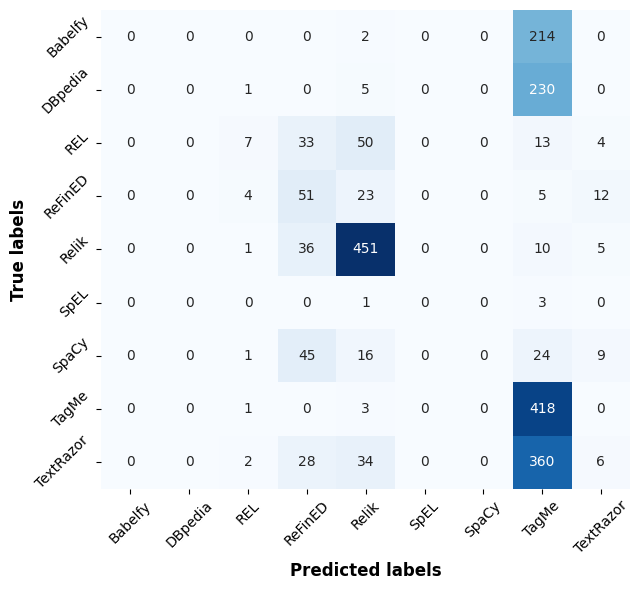

In [39]:
fig = plot_confusion_matrices(test_predictions=test_predictions, y_test=y_test)
# fig.savefig("CM_mlp_PCA.pdf", format="pdf", bbox_inches="tight")

In [40]:
def get_ds_name(idx):
    for ds in raw_text_labels_files:
        ds_name = ds['ds']
        ds = ds['raw']
        for _, value in ds.items():
            doc = value['doc']
            if doc_values[idx] == doc:
                return ds_name
    return None


In [41]:
ds_doc_topics = {}
for idx in idx_test:
    ds_name = get_ds_name(idx)
    if ds_name not in ds_doc_topics:
        ds_doc_topics[ds_name] = {}
        ds_doc_topics[ds_name]['doc'] = []
    document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[idx],reduced=True, num_topics=432897)
    ds_doc_topics[ds_name]['doc'].append({
        'text': doc_values[idx],
        'topics': document_topics,
        'scores': scores
    })

In [42]:
ds_doc_topics

{'/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json': {'doc': [{'text': 'Predicting MEK Inhibitor Response in Lung Cancer: A Proper Signature Is Required. The ERK signaling pathway is one of the most commonly deregulated pathways in cancer. Assays that accurately measure ERK signaling output in clinical specimens would be extremely helpfu l not only in determining the pharmacodynamic effects of drug treatment but also in selecting those patients most likely to respond to therapy. Clin Cancer Res; 23(6); 1365-7. ©2016 AACRSee related article by Brant et al., p. 1471.',
    'topics': array([[0, 8, 3, 4, 7, 9, 2, 1, 6, 5]]),
    'scores': array([[0.5106948 , 0.21831149, 0.21344317, 0.20399818, 0.19906159,
            0.15172166, 0.12054552, 0.10115118, 0.06822863, 0.05684891]],
          dtype=float32)},
   {'text': 'Use of Platelet Function Testing Before Pipeline Embolization Device Placement: A Multicenter Cohort Study. Thromboembo

In [43]:
def calculate_avgs(ds_doc_topics):
    for key, value in ds_doc_topics.items():
        topic_totals = {}
        topic_counts = {}

        value = value['doc']
        for sample in value:
            topics = sample['topics'][0]
            scores = sample['scores'][0]
            
            for topic, score in zip(topics, scores):
                if topic in topic_totals:
                    topic_totals[topic] += score
                    topic_counts[topic] += 1
                else:
                    topic_totals[topic] = score
                    topic_counts[topic] = 1

        topic_averages = {topic: topic_totals[topic] / topic_counts[topic] for topic in topic_totals}

        sorted_topics_total = sorted(topic_totals.items(), key=lambda item: item[1], reverse=True)
        sorted_topics_avg = sorted(topic_averages.items(), key=lambda item: item[1], reverse=True)
        ds_doc_topics[key]['topics'] = [f for f, _ in sorted_topics_total]
        ds_doc_topics[key]['avgs'] = [s if s > 0 else 0 for _, s in sorted_topics_avg]

In [44]:
calculate_avgs(ds_doc_topics=ds_doc_topics)

In [45]:
import random
def random_color():
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def plot_topics_vs(ds_doc_topics, title, y_offset, ncols):
    topics = reduced_topics_names_abbr #topics_names_reduced_abbr 
    avgs_matrix = np.zeros((len(ds_doc_topics), len(topics)))

    sorted_ds = sorted(ds_doc_topics.keys())

    for i, label in enumerate(sorted_ds):
        data = ds_doc_topics[label]
        for j, topic_index in enumerate(data['topics']):
            avgs_matrix[i, topic_index] = data['avgs'][j]

    bar_sums = avgs_matrix.sum(axis=0)  

    normalized_avgs_matrix = avgs_matrix / bar_sums[np.newaxis, :] 

    normalized_avgs_matrix = np.nan_to_num(normalized_avgs_matrix)

    fig, ax = plt.subplots(figsize=(6, 6))

    bar_width = 0.8
    bottoms = np.zeros(len(topics))  

    for i, label in enumerate(sorted_ds):
        predefined_colors = {
            'Babelfy': '#FF6347',  
            'DBpediaSpotlight': '#4682B4',  
            'REL MD (.properties)': '#32CD32',
            'Refined MD (.properties)': '#FF8C00',
            'Relik MD (.properties)': '#FFD700',
            'SpEL MD (.properties)': '#00FF7F',
            'Spacy MD (.properties)': '#FF69B4',
            'TagMe': '#8A2BE2', 
            'TextRazor': '#00CED1', 
            'AIDA-YAGO2-dataset.tsv_nif': '#FF4500',
            'KORE_50_DBpedia.ttl': '#1E90FF', 
            'News-100.ttl': '#228B22',  
            'RSS-500.ttl': '#FF1493', 
            'Reuters-128.ttl': '#DC143C',  
            'corpus_pubtator.json': '#4B0082'
        }
        predefined_labels = {
            'Babelfy': 'Babelfy',  
            'DBpediaSpotlight': 'DBpedia',  
            'REL MD (.properties)': 'REL',
            'Refined MD (.properties)': 'ReFinED',
            'Relik MD (.properties)': 'Relik',
            'SpEL MD (.properties)': 'SpEL',
            'Spacy MD (.properties)': 'SpaCy',
            'TagMe': 'TagMe', 
            'TextRazor': 'TextRazor', 
            'AIDA-YAGO2-dataset.tsv_nif': 'AIDA CoNLL-YAGO',
            'KORE_50_DBpedia.ttl': 'KORE 50', 
            'News-100.ttl': 'News-100',  
            'RSS-500.ttl': 'RSS-500', 
            'Reuters-128.ttl': 'Reuters-128',  
            'corpus_pubtator.json': 'MedMention'
        }
        default_color = random_color()
        label = label.split('/')[-1]
        color = predefined_colors.get(label, default_color)

        ax.bar(topics, normalized_avgs_matrix[i], bar_width, bottom=bottoms, label=predefined_labels[label], color=color)
        bottoms += normalized_avgs_matrix[i]  

    ax.set_xlabel('Topics', fontsize=12, fontweight="bold")
    ax.set_ylabel('Normalized Topic Scores', fontsize=12, fontweight="bold")
    ax.set_title(title)
    plt.xticks(rotation=45, ha='right', fontsize=12)

    ax.legend(loc='lower left', bbox_to_anchor=(y_offset, 1), ncols=ncols)





    plt.tight_layout()
    plt.show()
    return fig

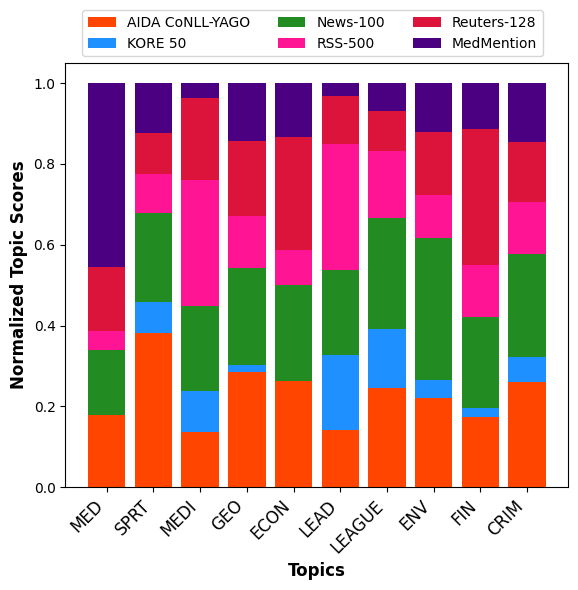

In [46]:
fig = plot_topics_vs(ds_doc_topics=ds_doc_topics, title="", ncols=3, y_offset=0.02)
fig.savefig("CM_mlp_PCA.pdf", format="pdf", bbox_inches="tight")
# Test only DS vs Topics

In [47]:
label_encoder.classes_

array(['Babelfy', 'DBpediaSpotlight', 'REL MD (.properties)',
       'Refined MD (.properties)', 'Relik MD (.properties)',
       'SpEL MD (.properties)', 'Spacy MD (.properties)', 'TagMe',
       'TextRazor'], dtype='<U24')

In [48]:
def gen_pred_sys_doc_topics(test_predictions, idx_test, model):
    sys_doc_topics = {}
    if model == "gt":
        for model_idx, original_idx in enumerate(idx_test):
            system = label_encoder.classes_[test_predictions[model_idx]]
            if system not in ds_doc_topics:
                sys_doc_topics[system] = {}
                sys_doc_topics[system]['doc'] = []
            document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[original_idx],reduced=True, num_topics=432897)
            sys_doc_topics[system]['doc'].append({
                'text': doc_values[original_idx],
                'topics': document_topics,
                'scores': scores
            })
        return sys_doc_topics
        
    for model_idx, original_idx in enumerate(idx_test):
        system = label_encoder.classes_[test_predictions[model][model_idx]]
        if system not in ds_doc_topics:
            sys_doc_topics[system] = {}
            sys_doc_topics[system]['doc'] = []
        document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[original_idx],reduced=True, num_topics=432897)
        sys_doc_topics[system]['doc'].append({
            'text': doc_values[original_idx],
            'topics': document_topics,
            'scores': scores
        })
    return sys_doc_topics

In [49]:
sys_doc_topics_gt_test = gen_pred_sys_doc_topics(test_predictions=y_test, idx_test=idx_test, model='gt')
calculate_avgs(sys_doc_topics_gt_test)

In [50]:
sys_doc_topics_gt_test

{'DBpediaSpotlight': {'doc': [{'text': 'Integrating Evidence From Systematic Reviews, Qualitative Research, and Expert Knowledge Using Co-Design Techniques to Develop a Web -Based Intervention for People in the Retirement Transition. Integrating stakeholder involvement in complex health intervention design maximizes acceptability and potential effectiveness. However, there is little methodological guidance about how to integrate evidence systematically from various sources in this process. Scientific evidence derived from different approaches can be difficult to integrate and the problem is compounded when attempting to include diverse, subjective input from stakeholders. The intent of the study was to describe and appraise a systematic, sequential approach to integrate scientific evidence, expert knowledge and experience, and stakeholder involvement in the co-design and development of a complex health intervention. The development of a Web -based lifestyle intervention for people in r

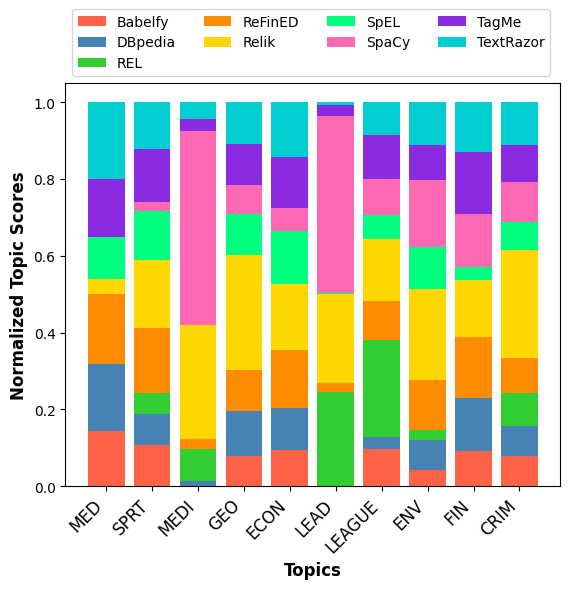

In [51]:
# GT TEST ONLY 
fig = plot_topics_vs(sys_doc_topics_gt_test, title="", y_offset=0, ncols=4)
# fig.savefig("systems_gt_test_only.pdf", format="pdf", bbox_inches="tight")

In [52]:
sys_doc_topics = gen_pred_sys_doc_topics(test_predictions=test_predictions, idx_test=idx_test, model='mlp')
calculate_avgs(sys_doc_topics)

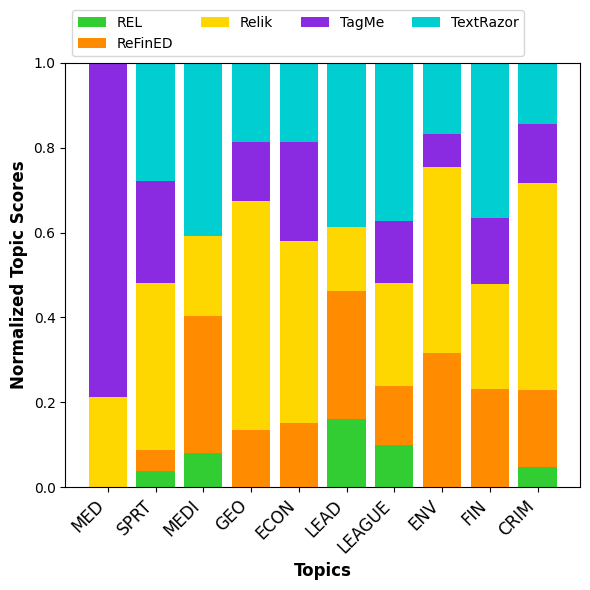

In [53]:
fig = plot_topics_vs(sys_doc_topics,title="", y_offset=0, ncols=4) 
fig.savefig("ohe.pdf", format="pdf", bbox_inches="tight")

In [54]:
import pickle

combOneHot = None

if COMPUTE_OR_LOAD:
    print("----------------- evaluate: combined one one encoding (noisy) ---------------------")
    combOneHot = evaluate(X_combined_one_hot, y)
    with open("combOneHot.pickle", "wb") as combOneHotFile:
        pickle.dump(combOneHot, combOneHotFile)
else:
    with open("combOneHot.pickle", "rb") as combOneHotFile:
        combOneHot = pickle.load(combOneHotFile)

In [55]:
# import pickle
# with open("combOneHot.pickle", "wb") as combOneHotFile:
#     pickle.dump(combOneHot, combOneHotFile)

In [56]:
# import pickle

# with open("combOneHot.pickle", "rb") as combOneHotFile:
#     combOneHot= pickle.load(combOneHotFile)

In [57]:
results_dict['combOneHot'] = combOneHot[0]

In [58]:
result, trainer, X_train, y_train, train_predictions, X_test, y_test, test_predictions, idx_train, idx_test = combOneHot

In [59]:
result

{'dummy_mf': {'accuracy': 0.23861480075901328,
  'f1_w': 0.09193661032691205,
  'recall_w': 0.23861480075901328,
  'precision_w': 0.05693702314126361,
  'f1_ma': 0.042810332354568284,
  'recall_ma': 0.1111111111111111,
  'precision_ma': 0.026512755639890365,
  'f1_mi': 0.23861480075901328,
  'recall_mi': 0.23861480075901328,
  'precision_mi': 0.23861480075901328,
  'best_params': {'dummy_mf': {},
   'dummy_un': {},
   'random_forest': {'max_depth': 20, 'n_estimators': 200},
   'svm': {'C': 1, 'kernel': 'rbf'},
   'knn': {'n_neighbors': 7, 'p': 2},
   'mlp': {'activation': 'tanh',
    'hidden_layer_sizes': (50,),
    'solver': 'sgd'}}},
 'dummy_un': {'accuracy': 0.10578747628083492,
  'f1_w': 0.12164227355724923,
  'recall_w': 0.10578747628083492,
  'precision_w': 0.16495738052645073,
  'f1_ma': 0.09037972847165508,
  'recall_ma': 0.09385529794702532,
  'precision_ma': 0.10714592724137482,
  'f1_mi': 0.10578747628083492,
  'recall_mi': 0.10578747628083492,
  'precision_mi': 0.1057874762

In [60]:
models = list(trainer.models.keys())

for model in models:
    for k in [2,3]:
        metrics_at_k(X_test, y_test, trainer, k=k, model=model)

precision@2 for :dummy_mf is 0.23268500948766604
recall@2 for    :dummy_mf is 0.44259962049335877
f1@2 for        :dummy_mf is 0.30501596607234627
precision@3 for :dummy_mf is 0.22248576850094445
recall@3 for    :dummy_mf is 0.6427893738140416
f1@3 for        :dummy_mf is 0.3305572547355057
precision@2 for :dummy_un is 0.20920303605313093
recall@2 for    :dummy_un is 0.4041745730550285
f1@2 for        :dummy_un is 0.2757014489052863
precision@3 for :dummy_un is 0.16018342820999298
recall@3 for    :dummy_un is 0.4492409867172675
f1@3 for        :dummy_un is 0.23616041491675688
precision@2 for :random_forest is 0.3517552182163188
recall@2 for    :random_forest is 0.6797912713472488
f1@2 for        :random_forest is 0.4636148334826258
precision@3 for :random_forest is 0.28905755850727366
recall@3 for    :random_forest is 0.8263757115749526
f1@3 for        :random_forest is 0.42830019868415437
precision@2 for :svm is 0.3709677419354839
recall@2 for    :svm is 0.7077798861480077
f1@2 for   

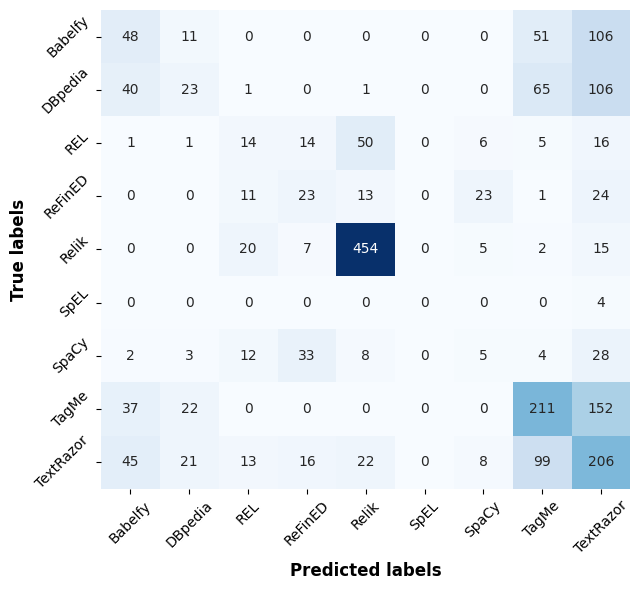

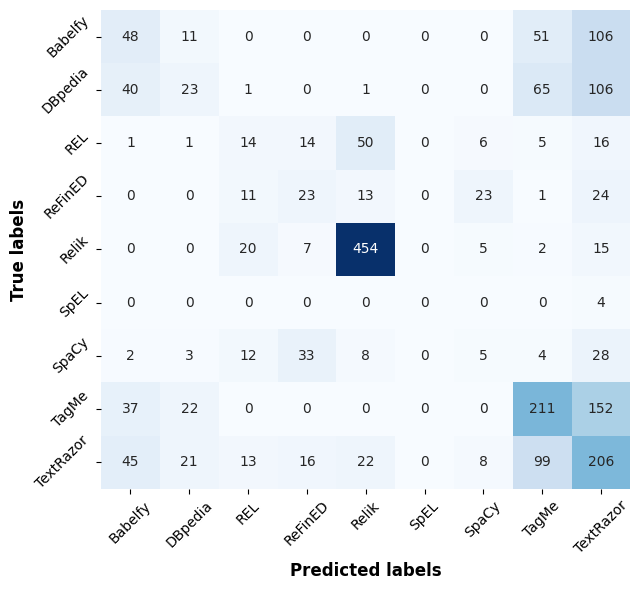

In [61]:
plot_confusion_matrices(test_predictions=test_predictions, y_test=y_test)

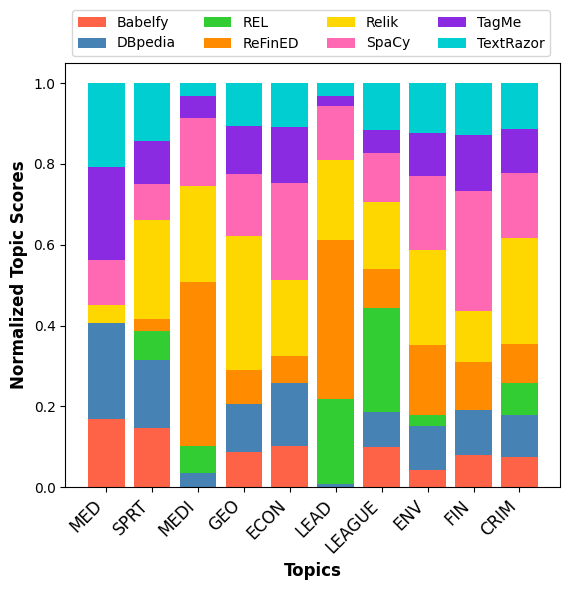

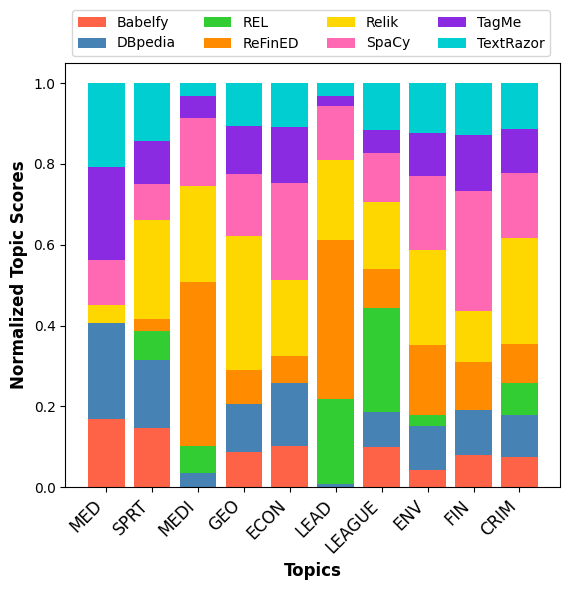

In [62]:
sys_doc_topics = gen_pred_sys_doc_topics(test_predictions=test_predictions, idx_test=idx_test, model="mlp")
calculate_avgs(sys_doc_topics)
plot_topics_vs(sys_doc_topics,title="", y_offset=0, ncols=4) 

In [63]:
# print("----------------- evaluate: doc emb only ---------------------")

# docEmbOnly = evaluate(X_emb_only, y)


In [64]:
import pickle
docEmbOnly= None
if COMPUTE_OR_LOAD:
    print("----------------- evaluate: doc emb only ---------------------")
    docEmbOnly = evaluate(X_emb_only, y)

    with open("docEmbOnly.pickle", "wb") as docEmbOnlyFile:
        pickle.dump(docEmbOnly, docEmbOnlyFile)
else:
    with open("docEmbOnly.pickle", "rb") as docEmbOnlyFile:
        docEmbOnly= pickle.load(docEmbOnlyFile)    

In [65]:
results_dict['docEmbOnly'] = docEmbOnly[0]

In [66]:
result, trainer, X_train, y_train, train_predictions, X_test, y_test, test_predictions, idx_train, idx_test = docEmbOnly

In [67]:
models = list(trainer.models.keys())

for model in models:
    for k in [2,3]:
        metrics_at_k(X_test, y_test, trainer, k=k, model=model)

precision@2 for :dummy_mf is 0.23268500948766604
recall@2 for    :dummy_mf is 0.44259962049335877
f1@2 for        :dummy_mf is 0.30501596607234627
precision@3 for :dummy_mf is 0.22248576850094445
recall@3 for    :dummy_mf is 0.6427893738140416
f1@3 for        :dummy_mf is 0.3305572547355057
precision@2 for :dummy_un is 0.20920303605313093
recall@2 for    :dummy_un is 0.4041745730550285
f1@2 for        :dummy_un is 0.2757014489052863
precision@3 for :dummy_un is 0.16018342820999298
recall@3 for    :dummy_un is 0.4492409867172675
f1@3 for        :dummy_un is 0.23616041491675688
precision@2 for :random_forest is 0.3510436432637571
recall@2 for    :random_forest is 0.6778937381404175
f1@2 for        :random_forest is 0.46255543220277445
precision@3 for :random_forest is 0.2857368753953189
recall@3 for    :random_forest is 0.812144212523719
f1@3 for        :random_forest is 0.422740772585441
precision@2 for :svm is 0.3719165085388994
recall@2 for    :svm is 0.7082542694497155
f1@2 for      

In [68]:
result

{'dummy_mf': {'accuracy': 0.23861480075901328,
  'f1_w': 0.09193661032691205,
  'recall_w': 0.23861480075901328,
  'precision_w': 0.05693702314126361,
  'f1_ma': 0.042810332354568284,
  'recall_ma': 0.1111111111111111,
  'precision_ma': 0.026512755639890365,
  'f1_mi': 0.23861480075901328,
  'recall_mi': 0.23861480075901328,
  'precision_mi': 0.23861480075901328,
  'best_params': {'dummy_mf': {},
   'dummy_un': {},
   'random_forest': {'max_depth': None, 'n_estimators': 200},
   'svm': {'C': 1, 'kernel': 'rbf'},
   'knn': {'n_neighbors': 7, 'p': 2},
   'mlp': {'activation': 'relu',
    'hidden_layer_sizes': (100,),
    'solver': 'sgd'}}},
 'dummy_un': {'accuracy': 0.11480075901328274,
  'f1_w': 0.12938515650711763,
  'recall_w': 0.11480075901328274,
  'precision_w': 0.1717550625650272,
  'f1_ma': 0.10058035860847306,
  'recall_ma': 0.13488937231326747,
  'precision_ma': 0.11524881013566156,
  'f1_mi': 0.11480075901328274,
  'recall_mi': 0.11480075901328274,
  'precision_mi': 0.11480075

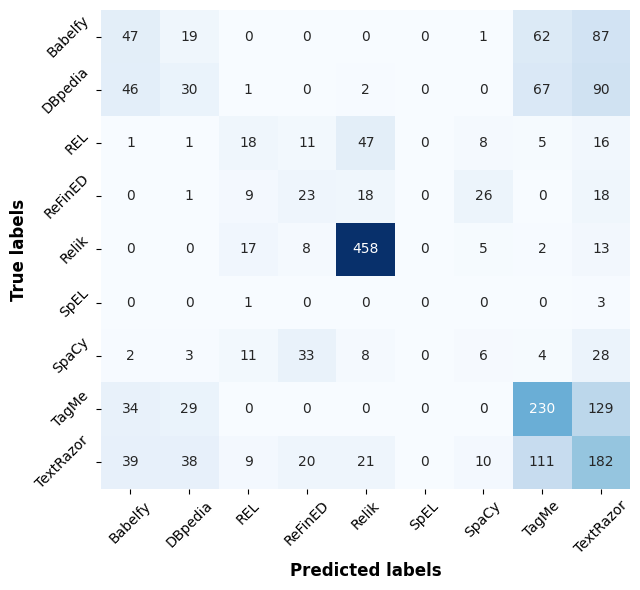

In [69]:
fig = plot_confusion_matrices(test_predictions=test_predictions, y_test=y_test)
fig.savefig("CM_mlp_PCA.pdf", format="pdf", bbox_inches="tight")

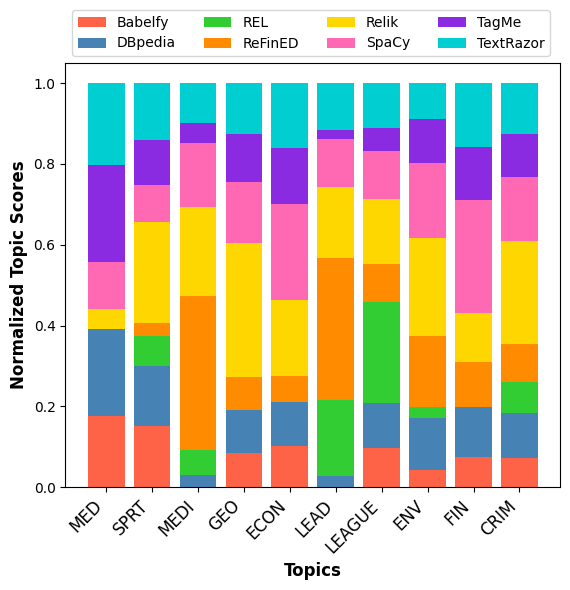

In [70]:
sys_doc_topics = gen_pred_sys_doc_topics(test_predictions=test_predictions, idx_test=idx_test, model='mlp')
calculate_avgs(sys_doc_topics)
fig = plot_topics_vs(sys_doc_topics,title="", y_offset=0, ncols=4) 
fig.savefig("emb_only.pdf", format="pdf", bbox_inches="tight")

In [71]:
oneHotPCA = None

if COMPUTE_OR_LOAD:
    print("----------------- evaluate: combined one one encoding (noisy) (PCA) ---------------------")
    oneHotPCA = evaluate(X_combined_one_hot_pca, y)
    with open("oneHotPCA.pickle", "wb") as oneHotPCAFile:
        pickle.dump(oneHotPCA, oneHotPCAFile)

else:
    with open("oneHotPCA.pickle", "rb") as oneHotPCAFile:
        oneHotPCA = pickle.load(oneHotPCAFile)

In [72]:
results_dict['oneHotPCA'] = oneHotPCA[0]

In [73]:
result, trainer, X_train, y_train, train_predictions, X_test, y_test, test_predictions, idx_train, idx_test = oneHotPCA

In [74]:
result

{'dummy_mf': {'accuracy': 0.23861480075901328,
  'f1_w': 0.09193661032691205,
  'recall_w': 0.23861480075901328,
  'precision_w': 0.05693702314126361,
  'f1_ma': 0.042810332354568284,
  'recall_ma': 0.1111111111111111,
  'precision_ma': 0.026512755639890365,
  'f1_mi': 0.23861480075901328,
  'recall_mi': 0.23861480075901328,
  'precision_mi': 0.23861480075901328,
  'best_params': {'dummy_mf': {},
   'dummy_un': {},
   'random_forest': {'max_depth': 10, 'n_estimators': 100},
   'svm': {'C': 0.1, 'kernel': 'linear'},
   'knn': {'n_neighbors': 7, 'p': 1},
   'mlp': {'activation': 'relu',
    'hidden_layer_sizes': (50,),
    'solver': 'sgd'}}},
 'dummy_un': {'accuracy': 0.10009487666034156,
  'f1_w': 0.11359156467985805,
  'recall_w': 0.10009487666034156,
  'precision_w': 0.14883684039614728,
  'f1_ma': 0.08637930487771872,
  'recall_ma': 0.08945970174656898,
  'precision_ma': 0.1001013695915649,
  'f1_mi': 0.10009487666034156,
  'recall_mi': 0.10009487666034156,
  'precision_mi': 0.100094

In [75]:
models = list(trainer.models.keys())

for model in models:
    for k in [2,3]:
        metrics_at_k(X_test, y_test, trainer, k=k, model=model)

precision@2 for :dummy_mf is 0.23055028462998103
recall@2 for    :dummy_mf is 0.4425996204933587
f1@2 for        :dummy_mf is 0.30317606139502795
precision@3 for :dummy_mf is 0.22090449082858524
recall@3 for    :dummy_mf is 0.6427893738140417
f1@3 for        :dummy_mf is 0.3288087715921653
precision@2 for :dummy_un is 0.20801707779886147
recall@2 for    :dummy_un is 0.4041745730550285
f1@2 for        :dummy_un is 0.2746695858731189
precision@3 for :dummy_un is 0.15907653383934156
recall@3 for    :dummy_un is 0.4492409867172675
f1@3 for        :dummy_un is 0.2349552548154769
precision@2 for :random_forest is 0.34321631878557873
recall@2 for    :random_forest is 0.666034155597723
f1@2 for        :random_forest is 0.4529971436662304
precision@3 for :random_forest is 0.2846299810246672
recall@3 for    :random_forest is 0.8202087286527515
f1@3 for        :random_forest is 0.42260647247028765
precision@2 for :svm is 0.36717267552182165
recall@2 for    :svm is 0.7054079696394687
f1@2 for     

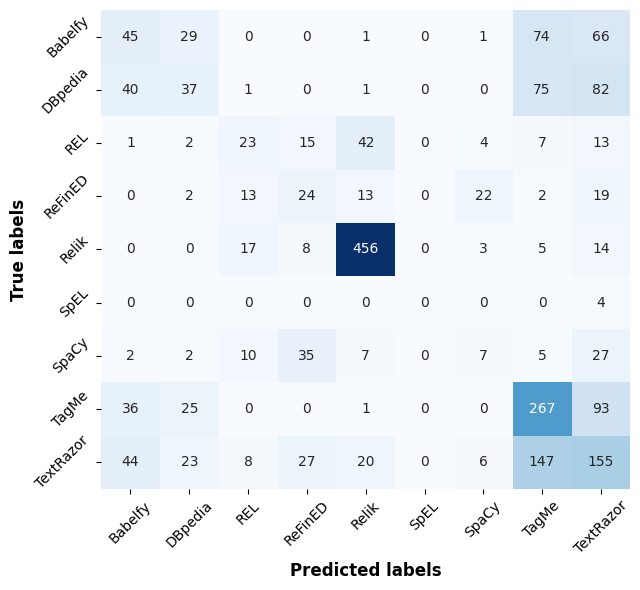

In [76]:
fig = plot_confusion_matrices(test_predictions=test_predictions, y_test=y_test)
fig.savefig("pca.pdf", format="pdf", bbox_inches="tight")

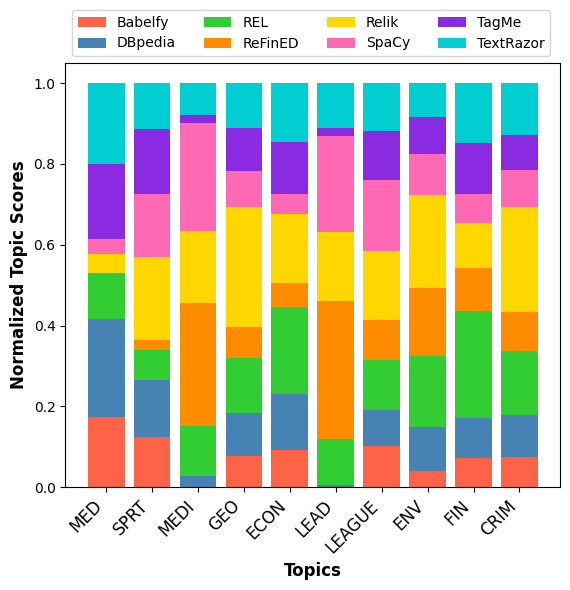

In [77]:
sys_doc_topics = gen_pred_sys_doc_topics(test_predictions=test_predictions, idx_test=idx_test, model='mlp')
calculate_avgs(sys_doc_topics)
fig = plot_topics_vs(sys_doc_topics,title="", y_offset=0, ncols=4) 
fig.savefig("pca.pdf", format="pdf", bbox_inches="tight")

In [78]:

# Extracting model names
models = list(results_dict['docEmbOnly'].keys())

# Extracting accuracies for each method
accuracy_doc_emb = [results_dict['docEmbOnly'][model]['accuracy'] for model in models]
accuracy_one_hot = [results_dict['combOneHot'][model]['accuracy'] for model in models]
accuracy_pca_one_hot_doc_emb = [results_dict['oneHotPCA'][model]['accuracy'] for model in models]
accuracy_one_hot_only = [results_dict['oneHotOnly'][model]['accuracy'] for model in models]

# Plotting Accuracy
plt.figure(figsize=(14, 8))
plt.plot(models, accuracy_doc_emb, marker='o', color='b', linestyle='-', label='Document embedding vector only')
plt.plot(models, accuracy_one_hot, marker='s', color='r', linestyle='--', label='One-hot encoded topics + Doc emb')
plt.plot(models, accuracy_pca_one_hot_doc_emb, marker='D', color='m', linestyle=':', label='PCA one hot + doc emb')
plt.plot(models, accuracy_one_hot_only, marker='*', color='orange', linestyle='-', label='One-hot encoded only')
plt.xticks(rotation=45)
plt.title('Accuracy of Models')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.tight_layout()

plt.show()

KeyError: 'oneHotOnly'

In [ ]:
ds_doc = {}
for ds in raw_text_labels_files:
    ds_doc[ds['ds']] = []
    for key, value in ds['raw'].items():
        ds_doc[ds['ds']].append(value['doc'])


In [ ]:
print(ds_doc.keys())
ds_doc['~/linker_topic_bias/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']

dict_keys(['/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl', '/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/Reuters/Reuters-128.ttl', '/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/News/News-100.ttl', '/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/RSS/RSS-500.ttl', '/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/ConllAIDA/AIDA-YAGO2-dataset.tsv_nif', '/mnt/webscistorage/wf7467/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json'])


KeyError: '/local/users/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl'

In [ ]:
def get_doc_id(text):
    for idx, doc in enumerate(doc_values):
        if doc == text:
            return idx
    return -1


In [ ]:
get_doc_id(ds_doc['~/linker_topic_bias/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl'][0])

0

In [ ]:
get_doc_id("Allen founded the EMP in Seattle, which featured exhibitions about Hendrix and Dylan, but also about various science fiction movies.")

0

In [ ]:
ds_doc_topics_gt = {}
not_treated = 0
for ds_name, list_docs in ds_doc.items():
    ds_doc_topics_gt[ds_name] = {}
    ds_doc_topics_gt[ds_name]['doc'] = []
    for doc in list_docs:
        if get_doc_id(doc) == -1:
            not_treated += 1
            continue
        document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[get_doc_id(doc)],reduced=True, num_topics=432897)
        ds_doc_topics_gt[ds_name]['doc'].append({
            'text': doc,
            'topics': document_topics,
            'scores': scores
        })


In [ ]:
ds_doc_topics_gt['~/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json']

{'doc': [{'text': 'DCTN4 as a modifier of chronic Pseudomonas aeruginosa infection in cystic fibrosis. Pseudomonas aeruginosa (Pa) infection in cystic fibrosis (CF) patients is associated with worse long-term pulmonary disease and shorter survival, and chronic Pa infection (CPA) is associated with reduced lung function, faster rate of lung decline, increased rates of exacerbations and shorter survival. By using exome sequencing and extreme phenotype design, it was recently shown that isoforms of dynactin 4 (DCTN4) may influence Pa infection in CF, leading to worse respiratory disease. The purpose of this study was to investigate the role of DCTN4 missense variants on Pa infection incidence, age at first Pa infection and chronic Pa infection incidence in a cohort of adult CF patients from a single centre. Polymerase chain reaction and direct sequencing were used to screen DNA samples for DCTN4 variants. A total of 121 adult CF patients from the Cochin Hospital CF centre have been includ

In [ ]:
print(scores)

[[ 0.60292846  0.2849866   0.20383161  0.16735822  0.15422857  0.1527293
   0.15142067  0.13365705  0.12974688  0.04311533  0.00724573 -0.05532874]]


In [ ]:
ds_doc_topics['~/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json']['avgs']

[0.5906189819146093,
 0.2858663888222322,
 0.2446995285769829,
 0.2213980762250316,
 0.16531878719062865,
 0.15935626704807787,
 0.13552133847914438,
 0.13219418681428,
 0.11933309219858694,
 0.10507895082559779,
 0.04876616731587317,
 0.04209039963978816]

In [ ]:

print(ds_doc_topics['~/linker_topic_bias/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']['topics'])
print(ds_doc_topics['~/linker_topic_bias/unjde/analysis/data/datasets/KORE50/KORE_50_DBpedia.ttl']['avgs'])

[10, 6, 7, 4, 3, 1, 9, 5, 8, 11, 2, 0]
[0.30022332933213974, 0.18599152035183378, 0.16962716844346787, 0.14734381569756402, 0.14350630442301432, 0.09097301695081923, 0.08891892962985569, 0.0876818921830919, 0.07966808213127984, 0.05536058213975695, 0.04625920719570584, 0.009876296255323621]


In [ ]:

print(ds_doc_topics['~/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json']['topics'])
print(ds_doc_topics['~/linker_topic_bias/unjde/analysis/data/datasets/medmention/corpus_pubtator.json']['avgs'])

[0, 2, 1, 9, 4, 5, 11, 7, 8, 3, 10, 6]
[0.5906189819146093, 0.2858663888222322, 0.2446995285769829, 0.2213980762250316, 0.16531878719062865, 0.15935626704807787, 0.13552133847914438, 0.13219418681428, 0.11933309219858694, 0.10507895082559779, 0.04876616731587317, 0.04209039963978816]


In [ ]:
topic_model.get_topics(num_topics=10)[0][7]

array(['lsu coach', 'coach', 'coach john', 'coach andy', 'les miles',
       'phil mickelson', 'steve stricker', 'oakland athletics',
       'lindsay davenport', 'inning tie', 'baltimore orioles', 'tnf il',
       'hernandez pitched', 'inzamam ul', 'ian healy', 'paul lawrie',
       'greenock morton', 'patrick rafter', 'nd', 'cyp cyp',
       'jason stoltenberg', 'boomer esiason', 'bobby valentine',
       'oakland baltimore', 'jeff wilson', 'fisher exact',
       'costas simitis', 'marcelo rios', 'spokesman dan',
       'cincinnati reds', 'justin marshall', 'waqar younis',
       'th halftime', 'last season', 'week ago', 'first baseman',
       'pete sampras', 'todd woodbridge', 'overs match', 'davis cup',
       'manager bobby', 'tnf', 'il tnf', 'michael chang', 'tony hayward',
       'lee westwood', 'andrew strauss', 'told reporters', 'police chief',
       'tim henman'], dtype='<U27')

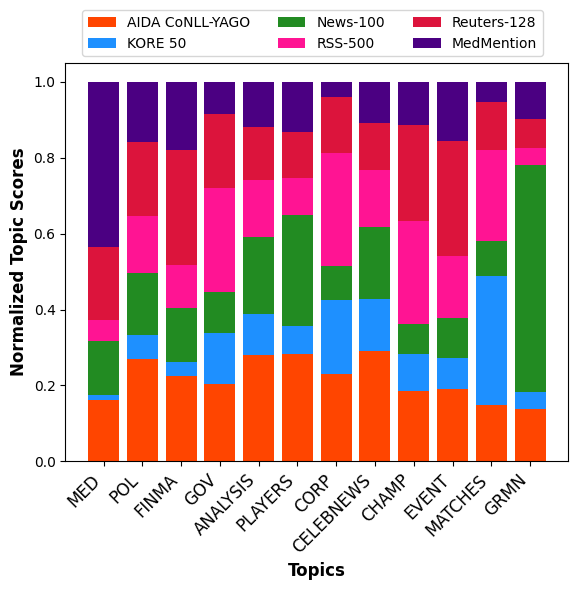

In [ ]:
calculate_avgs(ds_doc_topics_gt)
fig = plot_topics_vs(ds_doc_topics_gt, y_offset=0.02, title='', ncols=3)
fig.savefig("topics_vs_datasets_ground_truth_all.pdf", format="pdf", bbox_inches="tight")

In [ ]:
sys_doc_topics_gt = {}
not_treated = 0
for ds in raw_text_labels_files:
    ds = ds['raw']
    for key, doc_dict in ds.items():
        doc = doc_dict['doc']
        if get_doc_id(doc) == -1:
            not_treated += 1
            continue
        document_topics, scores, _, _ = topic_model.get_documents_topics(doc_ids=[get_doc_id(doc)],reduced=True, num_topics=432897)
        systems = [label['system'] for label in doc_dict['label']]
        for s in systems:
            if s not in sys_doc_topics_gt:
                sys_doc_topics_gt[s] = {}
                sys_doc_topics_gt[s]['doc'] = []
            sys_doc_topics_gt[s]['doc'].append({
                'text': doc,
                'topics': document_topics,
                'scores': scores
            })





In [ ]:
sys_doc_topics_gt['Babelfy']

{'doc': [{'text': 'The Relationship Between Distance and Post-operative Visit Attendance Following Medical Male Circumcision in Nyanza Province, Kenya. To date, there is no research on voluntary medical male circumcision (VMMC) catchment areas or the relationship between distance to a VMMC facility and attendance at a post-operative follow-up visit. We analyzed data from a randomly selected subset of males self-seeking circumcision at one of 16 participating facilities in Nyanza Province, Kenya between 2008 and 2010. Among 1437 participants, 46.7 % attended follow-up. The median distance from residence to utilized facility was 2.98 km (IQR 1.31-5.38). Nearly all participants (98.8 %) lived within 5 km from a facility, however, 26.3 % visited a facility more than 5 km away. Stratified results demonstrated that among those utilizing fixed facilities, greater distance was associated with higher odds of follow-up non-attendance (OR 5.01-10km vs. 0-1km = 1.71, 95 % CI 1.08, 2.70, p = 0.02; 

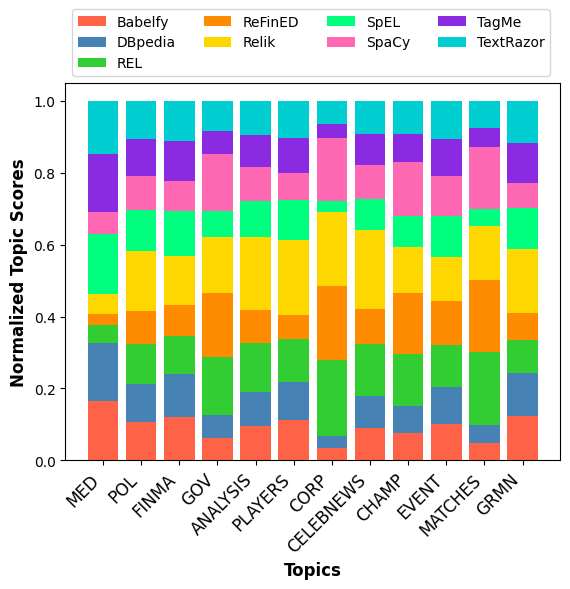

In [ ]:
calculate_avgs(sys_doc_topics_gt)
fig = plot_topics_vs(sys_doc_topics_gt, title="", y_offset=-0.0, ncols=4)
fig.savefig("systems_vs_datasets_ground_truth_all.pdf", format="pdf", bbox_inches="tight")